## Install libraries

In [ ]:
!pip install spacy==2.3.8
!python -m spacy download en
!pip install en_core_web_sm==2.3.1
!pip install seaborn==0.11.1
#!pip install sklearn==0.24.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 25.4 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.6
    Uninstalling srsly-2.4.6:
      Successfully uninstalled srsly-2.4.6
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.9
    Uninstalling thinc-8.1.9:
      Successfully uninstalled thinc-8.1.9
  Attempting uninstall: spacy
    Found existing i

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
import spacy

import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Read data

In [ ]:
df_p = pd.read_csv('DILIPositive.tsv', delimiter='\t', header=0)
df_p.head()

df_n = pd.read_csv('DILINegative.tsv', delimiter='\t', header=0)
df_n.head()

,PubMedID,Title,Abstract
0,4733,Huntington's chorea. Changes in neurotransmitt...,Neurotransmitter-receptor binding sites for ap...
1,19702,Natural history of lactic acidosis after grand...,To define the time course of the metabolic aci...
2,25385,A manpower policy for primary health care,A National Academy of Sciences study of policy...
3,61558,Multiple sclerosis cerebrospinal fluid produce...,To investigate the myelinotoxicity of cerebrop...
4,61560,Need for alpha-fetoprotein assays,An alpha fetoprotein assay is useful in diagno...


In [ ]:
# Combine title and abstract
DATA=2     # 0: Title, 1: Abstract, 2: Title+Abstract
if DATA==0:
  df_p['Title_Abstract'] = df_p['Title'].fillna('') 
  df_n['Title_Abstract'] = df_n['Title'].fillna('')
elif DATA==1:
  df_p=df_p[~df_p['Abstract'].isnull()]
  df_p['Title_Abstract'] = df_p['Abstract'].fillna('') 

  df_n=df_n[~df_n['Abstract'].isnull()]
  df_n['Title_Abstract'] = df_n['Abstract'].fillna('')
else: 
  df_p['Title_Abstract'] = df_p['Title'] + (' ' + df_p['Abstract']).fillna('')
  df_n['Title_Abstract'] = df_n['Title'] + (' ' + df_n['Abstract']).fillna('')

df_p['Class']='Positive'
df_p_=df_p.iloc[:,3:5]
df_p_.head()

df_n['Class']='Negative'
df_n_=df_n.iloc[:,3:5]
df_n_.head()

frames = [df_p_, df_n_]
df=pd.concat(frames)

In [ ]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [ ]:
P_text = [text for text in df[df['Class'] == 'Positive']['Title_Abstract']]
N_text = [text for text in df[df['Class'] == 'Negative']['Title_Abstract']]

P_clean = cleanup_text(P_text)
P_clean = ' '.join(P_clean).split()

N_clean = cleanup_text(N_text)
N_clean = ' '.join(N_clean).split()

P_counts = Counter(P_clean)
N_counts = Counter(N_clean)

## Word frequency

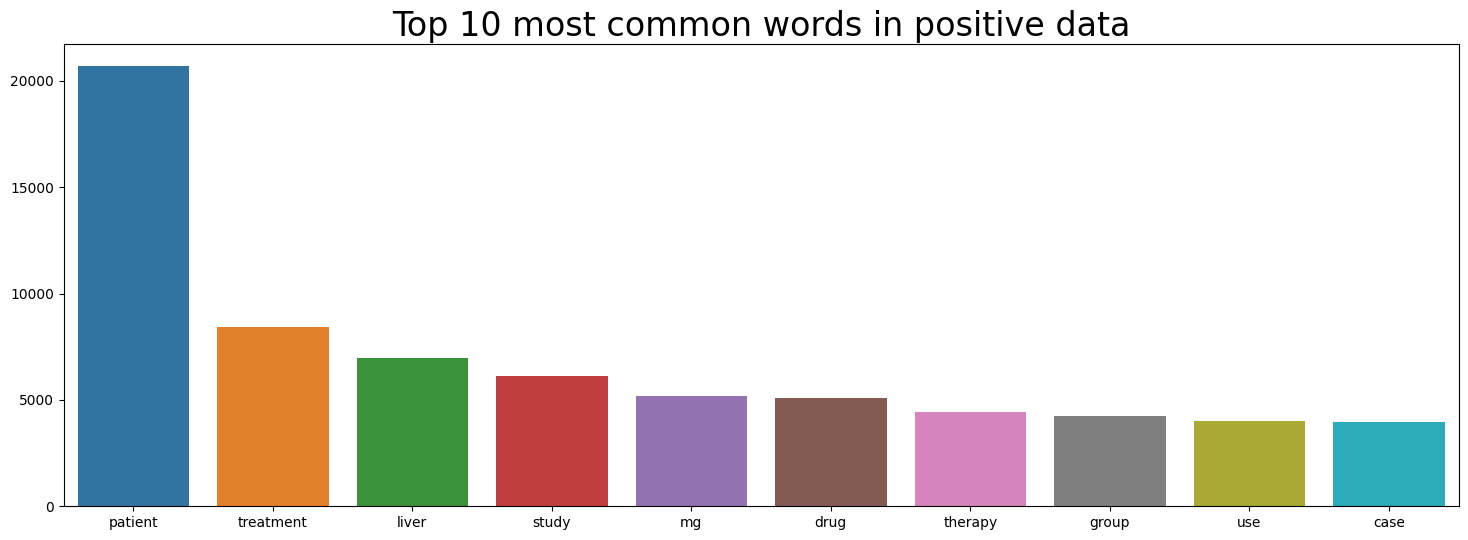

In [ ]:
P_common_words = [word[0] for word in P_counts.most_common(10)]
P_common_counts = [word[1] for word in P_counts.most_common(10)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=P_common_words, y=P_common_counts)
sns.set(font_scale=2)
plt.title('Top 10 most common words in positive data')
plt.show()

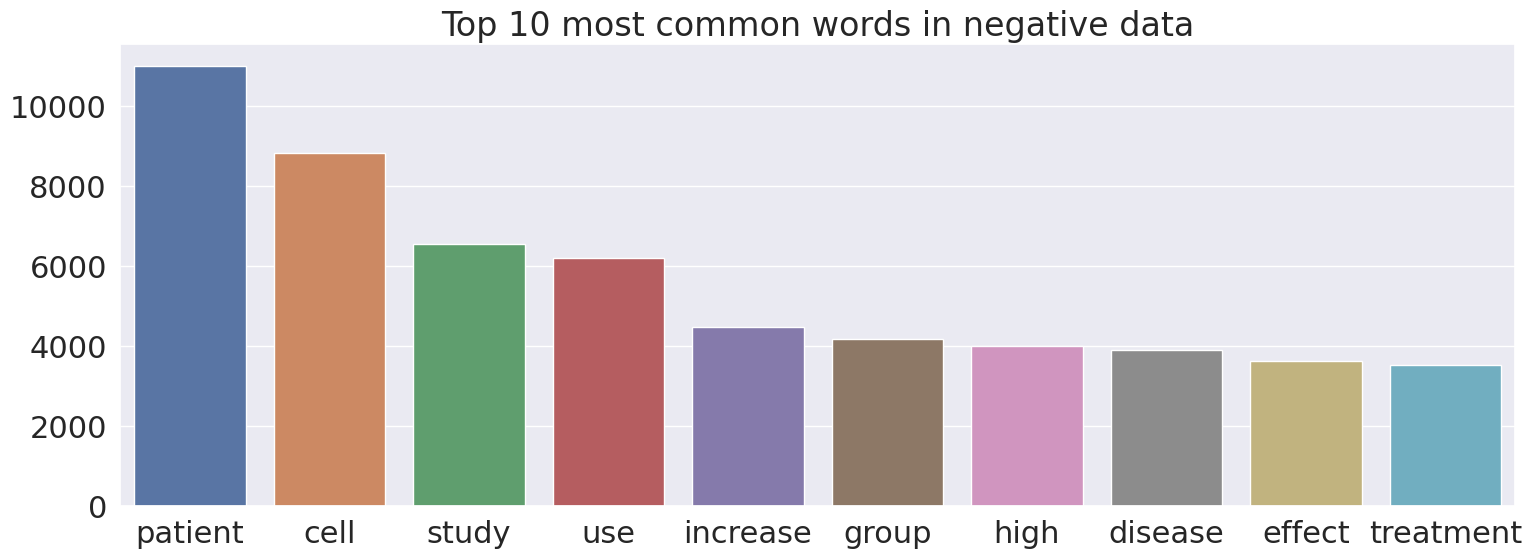

In [ ]:
N_common_words = [word[0] for word in N_counts.most_common(10)]
N_common_counts = [word[1] for word in N_counts.most_common(10)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=N_common_words, y=N_common_counts)
plt.title('Top 10 most common words in negative data')
plt.show()

## Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS 
from nltk.corpus import stopwords
from spacy.lang.en import English

spacy.load('en')
parser = English()

In [ ]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [ ]:
# Tokenization
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [ ]:
x_df = df['Title_Abstract'].tolist()
y_df = df['Class'].tolist()

# Tokenization
vectorizer = TfidfVectorizer(tokenizer=tokenizeText, ngram_range=(1,1)) # TfidfVectorizer > CountVectorizer
X = vectorizer.fit_transform(x_df)
B = np.asarray(X.todense())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## TSNE

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(B)

/usr/local/lib/python3.10/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


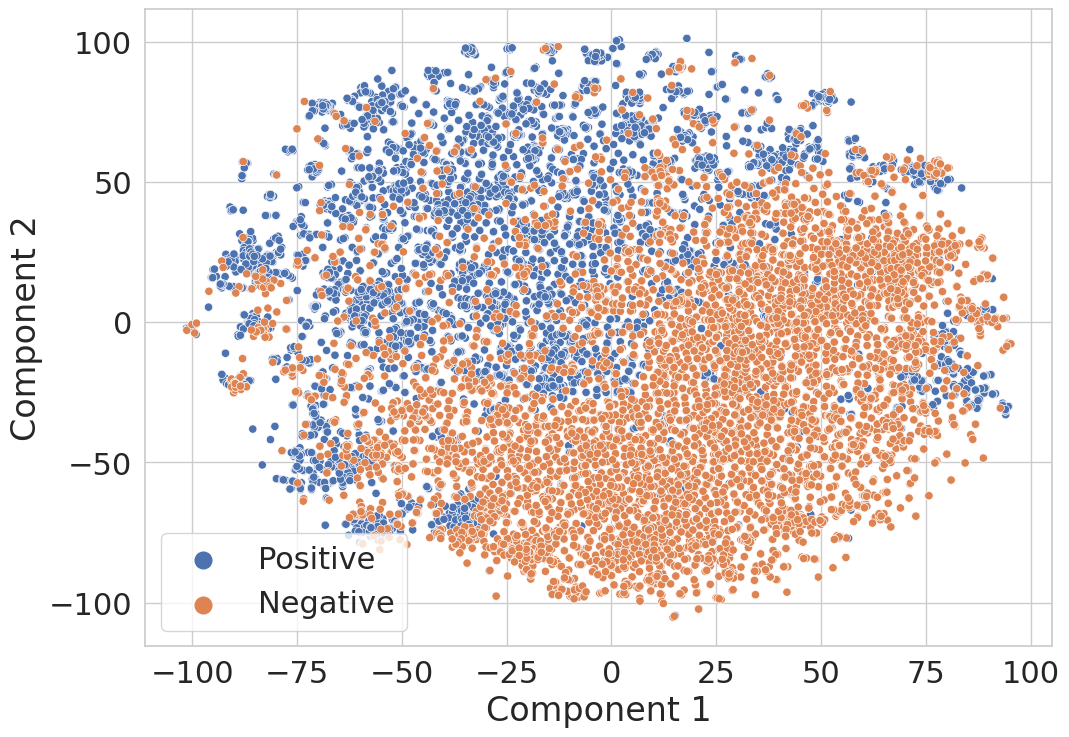

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.set(font_scale = 2)
sns.set_style("whitegrid")
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_df, legend='full')

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(markerscale=2)

## PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_embedded=pca.fit_transform(B)

/usr/local/lib/python3.10/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


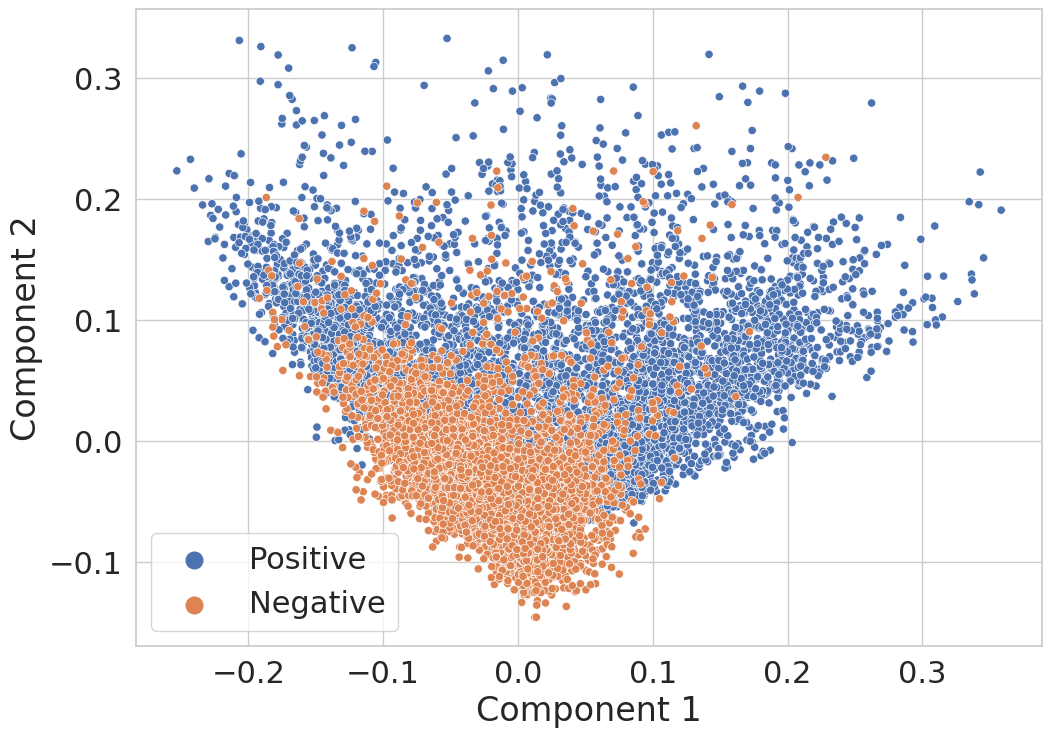

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.set(font_scale = 2)
sns.set_style("whitegrid")
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_df, legend='full')

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(markerscale=2)